In [1]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,concatenate, Dropout, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten,Conv2D, Convolution2D, Reshape
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D,Conv2DTranspose
from tensorflow.keras.models import Model
import mlflow

In [2]:
import cv2 
import glob 
import os 
import numpy as np

In [3]:
class Config:
    MLFLOW_TRACKING_URL = './AllExperimentsIIIThyd'
    MLFLOW_EXPERIMENT_NAME = 'IRIS unet'
    EPOCHS = 2
    BATCH_SIZE = 5

In [4]:
#rm -r mlruns

MLFlow Related logic in next cell

In [5]:
# mlflow.set_tracking_uri(Config.MLFLOW_TRACKING_URL)#sets the tracking url to get the list of experiments etc
# mlflow_client = mlflow.tracking.MlflowClient(Config.MLFLOW_TRACKING_URL)
# experiments = mlflow_client.list_experiments()

# experiment_names = list(map(lambda x:x.name,experiments))

# if Config.MLFLOW_EXPERIMENT_NAME in experiment_names:
#     experiment = mlflow_client.get_experiment_by_name(Config.MLFLOW_EXPERIMENT_NAME)
#     experiment_id = experiment.experiment_id
#     print("experiment exists with id:",experiment_id)
    
# else:
#     experiment_id = mlflow_client.create_experiment(Config.MLFLOW_EXPERIMENT_NAME)
#     print('Experiment created with id: ',experiment_id)
    
# print("Tracking URL: ", mlflow.get_tracking_uri())
# print("Active_run", mlflow.active_run())
    

In [6]:
try:
    id_exp = mlflow.create_experiment('IRIS_Dataset_Unet')
except Exception as e:
    print(e)

Experiment 'IRIS_Dataset_Unet' already exists.


In [7]:
ls ./mlruns/1/

meta.yaml


In [8]:
NO_OF_TRAINING_IMAGES = len(os.listdir('/data/train'))
NO_OF_VAL_IMAGES = len(os.listdir('/data/test'))


In [9]:
NO_OF_TRAINING_IMAGES

2

In [10]:
train_in_images_path = '/data/train/'
train_in_labels_path  = '/data/mask/'
test_in_images_path = '/data/test/'
test_in_labels_path = '/data/mask_test/'

In [11]:
def load_img_data_tensor(path,h,w,c):
    N = len(os.listdir(path))
    data_out= np.zeros((N,h,w,c),'float')
    
    for i in range(0,N):
        
        img_name = os.listdir(path)[i]
        
        img = cv2.imread(path + img_name)
        img = cv2.resize(img,(256,256))
        if(c >1):
            
            img_rgb = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
            data_out[i] = img_rgb
        else:
            
            img_gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            
            data_out[i] = np.expand_dims(img_gray, axis=2)
        
        #print (i)
    return data_out
            
            
        
    
    
    

In [12]:

img_height = 256 
img_width = 256

train_image_orig = load_img_data_tensor(train_in_images_path,img_height,img_width,3)
train_mask_orig = load_img_data_tensor(train_in_labels_path,img_height,img_width,1)
val_image_orig = load_img_data_tensor(test_in_images_path,img_height,img_width,3)
val_mask_orig = load_img_data_tensor(test_in_labels_path,img_height,img_width,1)

In [13]:
X_train = train_image_orig/255.
X_test = val_image_orig/255.
Y_train = train_mask_orig/255.
Y_test = val_mask_orig/255.
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 2
number of test examples = 2
X_train shape: (2, 256, 256, 3)
Y_train shape: (2, 256, 256, 1)
X_test shape: (2, 256, 256, 3)
Y_test shape: (2, 256, 256, 1)


In [14]:
def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    """Function to add 2 convolutional layers with the parameters passed to it"""
    # first layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # second layer
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),\
              kernel_initializer = 'he_normal', padding = 'same')(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [15]:
def Unet_model(input_shape,n_filters=16,dropout=.1,batchnorm=True):
    
    X_input = Input(input_shape)
    
    c1 = conv2d_block(X_input,n_filters*1,kernel_size=3,batchnorm=batchnorm)     
    p1 = MaxPooling2D((2,2))(c1)           # (h/2,w/2,16)
    p1 = Dropout(dropout)(p1) 
    
    c2 = conv2d_block(p1,n_filters*2,kernel_size=3,batchnorm=batchnorm)
    p2 = MaxPooling2D((2,2))(c2)  # (h/4,w/4,32)
    p2 = Dropout(dropout)(p2) 
    
    c3 = conv2d_block(p2,n_filters*4,kernel_size=3,batchnorm=batchnorm)
    p3 = MaxPooling2D((2,2))(c3)  # (h/8,w/8,64)
    p3 = Dropout(dropout)(p3) 
    
    c4 = conv2d_block(p3,n_filters*8,kernel_size=3,batchnorm=batchnorm)
    p4 = MaxPooling2D((2,2))(c4)  # (h/16,w/16,128)
    p4 = Dropout(dropout)(p4) 
    
    c5 = conv2d_block(p4,n_filters*16,kernel_size=3,batchnorm=batchnorm)      # (h/16,w/16,256)

    
    print("encoder done")
    
    
    u6 = Conv2DTranspose(n_filters * 8, (3, 3), strides = (2, 2), padding = 'same')(c5)  # (h/8,w/8,128)
    u6 = concatenate([u6, c4])   # (h/8,w/8,128)
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters * 8, kernel_size = 3, batchnorm = batchnorm)     # (h/8,w/8,128)
    
    u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2), padding = 'same')(c6)  # (h/4,w/4,64)
    u7 = concatenate([u7, c3])   # (h/8,w/8,128)
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters * 4, kernel_size = 3, batchnorm = batchnorm)     # (h/4,w/4,64)
    
    u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2), padding = 'same')(c7)  # (h/2,w/2,32)
    u8 = concatenate([u8, c2])   # (h/2,w/2,32)
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters *2 , kernel_size = 3, batchnorm = batchnorm)     # (h/2,w/2,32)
    
    u9 = Conv2DTranspose(n_filters, (3, 3), strides = (2, 2), padding = 'same')(c8)  # (h,w,16)
    u9 = concatenate([u9, c1])   # (h,w,16)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters, kernel_size = 3, batchnorm = batchnorm)     # (h,w,16)    
    
    
    print("decoder done")
    X_outputs = Conv2D(1,(1,1),activation='sigmoid')(c9)
    
    model = Model(inputs=X_input,outputs=X_outputs,name='Unet_model')
    
    return model
    
    
    
    

In [16]:
unetmodel = Unet_model((256,256,3))

/usr/local/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


encoder done
decoder done


In [17]:
unetmodel.compile(loss='binary_crossentropy', optimizer="Adam", metrics = ["accuracy"])

/usr/local/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


In [18]:
ls

51_1.bmp*               mask/       unet_model_ML_flow.ipynb
52_1.bmp*               mask_test/  unet_model_UBIRIS_1.h5
52_2.bmp*               mlruns/     unet_model_ubiris.ipynb
AllExperimentsIIIThyd/  test/
code/                   train/


In [19]:
with mlflow.start_run():
    unetmodel.fit(x = X_train, y = Y_train, epochs = Config.EPOCHS, batch_size = Config.BATCH_SIZE)
    mlflow.log_param('BATCH_SIZE',Config.BATCH_SIZE)
    mlflow.log_param('EPOCHS', Config.EPOCHS)
    model_save_path = '/data/unet_model_UBIRIS_1.h5'
    unetmodel.save(model_save_path)
    mlflow.log_artifact('/data/unet_model_UBIRIS_1.h5')

/usr/local/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


Epoch 1/2
2/2 [==============================] - 3s 1s/step - loss: 0.7235 - acc: 0.4904
Epoch 2/2
2/2 [==============================] - 1s 353ms/step - loss: 0.6306 - acc: 0.6291


In [20]:
# model_save_path = '/data/unet_model_UBIRIS_1.h5'

# unetmodel.save(model_save_path)

In [21]:
ls -ltr ./AllExperimentsIIIThyd/

total 8
drwxr-xr-x 2 root root 4096 Jan 30 02:20 1/
drwxr-xr-x 4 root root 4096 Jan 30 02:20 0/


In [22]:
ls -ltr ./mlruns/0/

total 16
-rw-r--r-- 1 root root   98 Jan 30 02:24 meta.yaml
drwxr-xr-x 6 root root 4096 Jan 30 02:25 fe99a015fee84571831459a4b689e6df/
drwxr-xr-x 6 root root 4096 Jan 30 02:25 f74f96be52784c76bc80d83111a4eeec/
drwxr-xr-x 6 root root 4096 Jan 30 02:31 29a08c4e16944fab994f7038a9ab7a8a/


In [23]:
X_test[0:1].shape

(1, 256, 256, 3)

In [24]:
preds = unetmodel.predict(X_test[0:1])

/usr/local/lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
  return _inspect.getargspec(target)


In [25]:
preds.shape

(1, 256, 256, 1)

In [26]:
import matplotlib.pyplot as plt

In [27]:
out_image = np.squeeze(preds)


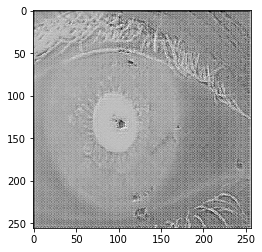

In [28]:
plt.imshow(out_image,cmap='gray')
plt.show()

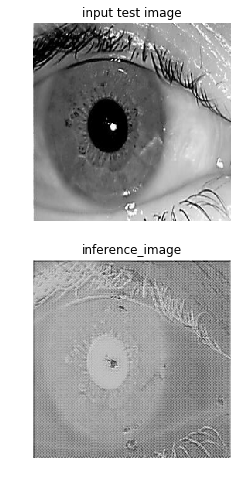

In [29]:
fig=plt.figure(figsize=(8, 8))
columns = 1
rows = 2
fig.add_subplot(rows, columns, 1)
plt.axis("off")
plt.title("input test image")
plt.imshow(X_test[0])
fig.add_subplot(rows, columns, 2)
plt.axis("off")
plt.title("inference_image")
plt.imshow(out_image,cmap='gray')

In [ ]:
!mlflow ui --host 0.0.0.0

[2020-01-30 02:31:25 +0000] [973] [INFO] Starting gunicorn 20.0.4
[2020-01-30 02:31:25 +0000] [973] [INFO] Listening at: http://0.0.0.0:5000 (973)
[2020-01-30 02:31:25 +0000] [973] [INFO] Using worker: sync
[2020-01-30 02:31:25 +0000] [976] [INFO] Booting worker with pid: 976
2020/01/30 02:31:36 ERROR mlflow.server: Exception on /ajax-api/2.0/preview/mlflow/model-versions/search [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.5/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/usr/local/lib/python3.5/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/usr/local/lib/python3.5/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/usr/local/lib/python3.5/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/usr/local/lib/python3.5/site-packages/flask/app.py", line 1949, i

In [ ]:
ls mlruns/0/

In [ ]:
ls